## 2DCNN + BiLSTM model evalutaion

In [1]:
import pandas as pd
import joblib as jbl
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

### Getting the split first

In [2]:
def get_train_test_indeces(Y_path, shuffle: bool = True, test_size: float = None, combine_double_labels: bool = False, one_hot_emotions: bool = True):
    labels = pd.read_csv(Y_path, index_col="Unnamed: 0")
    labels["emotion"] = labels["emotion"].apply(lambda x: x.lower())
    mlb_df = pd.DataFrame()
    if "subject" in labels.columns:
        labels.drop("subject", axis=1, inplace=True)
    if combine_double_labels:
        map_dict = {
        'happiness': 'happiness',
        'positive': 'positive',
        'surprise+positive': 'positive', 
        'disgust': 'disgust',
        'negative': 'negative',
        'sadness': 'sadness',
        'surprise+negative': 'surprise',
        'repression': 'repression',
        'positive+repression': 'repression',
        'negative+repression': 'repression',
        'surprise+repression': 'repression',
        'surprise': 'surprise',
        'fear': 'others',  # rare
        'others': 'others'
        }
        labels['emotion'] = labels['emotion'].replace(map_dict)
    test_idx = None
    train_idx = None
    indeces = np.arange(len(labels))
    train_idx, test_idx =  train_test_split(indeces, test_size=test_size, stratify=labels['emotion'], shuffle=shuffle, random_state=341)
    if one_hot_emotions:
        mlb_df["emotion"]  = labels["emotion"].apply(lambda x: x.split("+"))
        mlb = MultiLabelBinarizer().fit(mlb_df["emotion"])
        transform = mlb.transform(mlb_df["emotion"])
        mlb_df[mlb.classes_] = transform
        mlb_df.drop("emotion", axis=1, inplace=True)
        return train_idx, test_idx, labels, mlb_df
    return train_idx, test_idx, labels

train_idx, test_idx, labels = get_train_test_indeces("../data/union+subject.csv", shuffle=True, test_size=0.2, one_hot_emotions=False, combine_double_labels=True)
display(labels.head(5))

,AU5,AU24,AU43,AU64,AU17,AU7,AU1,AU20,AU39,AU6,...,AU15,AU12,AU16,AU63,AU10,AU45,AU26,AU9,AU25,emotion
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,happiness
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,others


## Sampling -> Magnification -> Optical Flow

In [3]:
data_casme = jbl.load("../data/casme_mag_of.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_mag_of.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


In [4]:
CASME_SIZE = 256
FDME_SIZE = 267

labels["emotion"] = labels["emotion"].apply(lambda x: x.lower())
NUM_EMOTIONS = len(labels["emotion"].unique())
NUM_AUS = len(labels.columns[1:])
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]
le = LabelEncoder()
le.fit(labels["emotion"])
emotions = le.transform(labels["emotion"])
aus = labels[labels.columns[:-1]].to_numpy()
DATA_SIZE = concatted.shape[0]

We need to alter the class weights for emotions

In [5]:
emotion_counts = labels["emotion"].value_counts()
display(emotion_counts)
display(labels[labels.columns[:-1]].sum())
inverse_freq = 1 / emotion_counts.values
inverse_freq = np.ceil(20 * (inverse_freq / np.max(inverse_freq)))
codes = le.transform(emotion_counts.keys())
arg_sorted = np.argsort(codes)
class_weights = inverse_freq[arg_sorted]

emotion
others        132
negative      127
disgust        64
surprise       62
repression     51
positive       48
happiness      32
sadness         7
Name: count, dtype: int64

AU5      10
AU24     11
AU43      1
AU64      1
AU17     36
AU7     128
AU1      72
AU20      3
AU39      4
AU6      38
AU4     232
AU2      76
AU38      2
AU18      1
AU14     31
AU15     22
AU12     87
AU16      1
AU63      2
AU10     18
AU45     34
AU26      1
AU9      14
AU25      2
dtype: int64

In [6]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)
'''
dataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)
validation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
training = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)
'''

'\ndataset = tf.data.Dataset.from_tensor_slices((concatted, (emotions, aus))).shuffle(buffer_size=DATA_SIZE, seed = 255).batch(1)\nvalidation = dataset.skip(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\ntraining = dataset.take(int(DATA_SIZE*0.65)).prefetch(tf.data.AUTOTUNE)\n'

In [ ]:
class_weights = tf.cast(tf.constant(class_weights), dtype=tf.float32)

def weighted_loss(y_true, y_pred):
    weight = tf.gather(class_weights, y_true)
    loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return loss * weight

def basic_block(inputs, filter_num, stride=1):
    x = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=stride, padding="same")(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(3, 3), strides=1,padding="same")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    shortcut = inputs
    if stride != 1 or filter_num != inputs.shape[0]:
        shortcut = tf.keras.layers.Conv2D(filters=filter_num, kernel_size=(1, 1), strides=stride)(inputs)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    x = tf.keras.layers.add([x, shortcut])
    x = tf.keras.layers.Activation('relu')(x)
    return x

def make_blocks(inputs, filter_num, blocks, stride=1):
    x = basic_block(inputs, filter_num, stride=stride)
    for _ in range(1, blocks):
        x = basic_block(x, filter_num, stride=1)
    return x

def frame_encoder(input_shape=None, pooling=None):
    img_input = tf.keras.layers.Input(shape=input_shape)
    
    x = tf.keras.layers.ZeroPadding2D(padding=(3, 3))(img_input)
    x = tf.keras.layers.Conv2D(32, (7, 7), strides=(2, 2), padding='valid')(x) #kernel_initialzer = "he_norm" #32
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = make_blocks(x, filter_num=64, blocks=1, stride=1) #blocks 1
    x = make_blocks(x, filter_num=128, blocks=1, stride=2) #blocks 2,  downsampling
    x = make_blocks(x, filter_num=256, blocks=1, stride=2) #blocks 2, downsampling
    x = tf.keras.layers.Dropout(0.2)(x)
   # x = tf.keras.layers.Conv2D(, (3, 3), strides=2, padding='same', activation='relu')(x)
   # x = tf.keras.layers.Dropout(0.4)(x)
    
    if pooling == 'avg':
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
    elif pooling == 'max':
        x = tf.keras.layers.GlobalMaxPooling2D()(x)
    model = tf.keras.Model(img_input, x)
    return model

def build_2d_bilstm(input_shape=(8, 112, 112, 1), num_emotions=7, num_aus=12, lstm_hidden=128, dropout_f = 0.2):
    """
    input_shape: (T, H, W, C)
    Uses TimeDistributed 2D encoder, BiLSTM across time, temporal pooling, heads.
    Also added 3D CONV block, boosted up performence by around 5%
    """
    video_in = tf.keras.layers.Input(shape=input_shape, name="video_in")  # (T, H, W, C)
    x = tf.keras.layers.Conv3D(32, (3,7,7), strides=(1,2,2), padding="same")(video_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling3D((1,3,3), strides=(1,2,2), padding="same")(x)
    x = tf.keras.layers.Conv3D(32, (3,1,1), strides=1, padding="same", activation="relu")(x)
    B, T, H, W, C = x.shape
    encoder = frame_encoder(input_shape=(H,W,C), pooling="max")
    # TimeDistributed encoder: output shape (batch, T, cnn_feat_dim)
    td = tf.keras.layers.TimeDistributed(encoder, name="td_encoder")(x)

    # BiLSTM
    rnn = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_hidden, dropout = 0.1))(td)

    # temporal pooling (mean)
    #pooled = tf.keras.layers.GlobalAveragePooling1D(name="temporal_mean")(rnn)  # (batch, 2*lstm_hidden)
    dense = tf.keras.layers.Dense(lstm_hidden, activation="relu")(rnn)
    dropout = tf.keras.layers.Dropout(dropout_f)(dense)
    emotion_logits = tf.keras.layers.Dense(num_emotions, name="emotion_logits", activation="softmax")(dropout)
    au_logits = tf.keras.layers.Dense(num_aus, name="au_logits", activation="sigmoid")(dropout)

    model = tf.keras.Model(inputs=video_in, outputs=[emotion_logits, au_logits], name="2D_BiLSTM") # au_logits]
    return model

Model: "2D_BiLSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 video_in (InputLayer)          [(None, 7, 224, 224  0           []                               
                                , 3)]                                                             
                                                                                                  
 conv3d (Conv3D)                (None, 7, 112, 112,  14144       ['video_in[0][0]']               
                                 32)                                                              
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 112, 112,  128        ['conv3d[0][0]']                 
 alization)                      32)                                                      

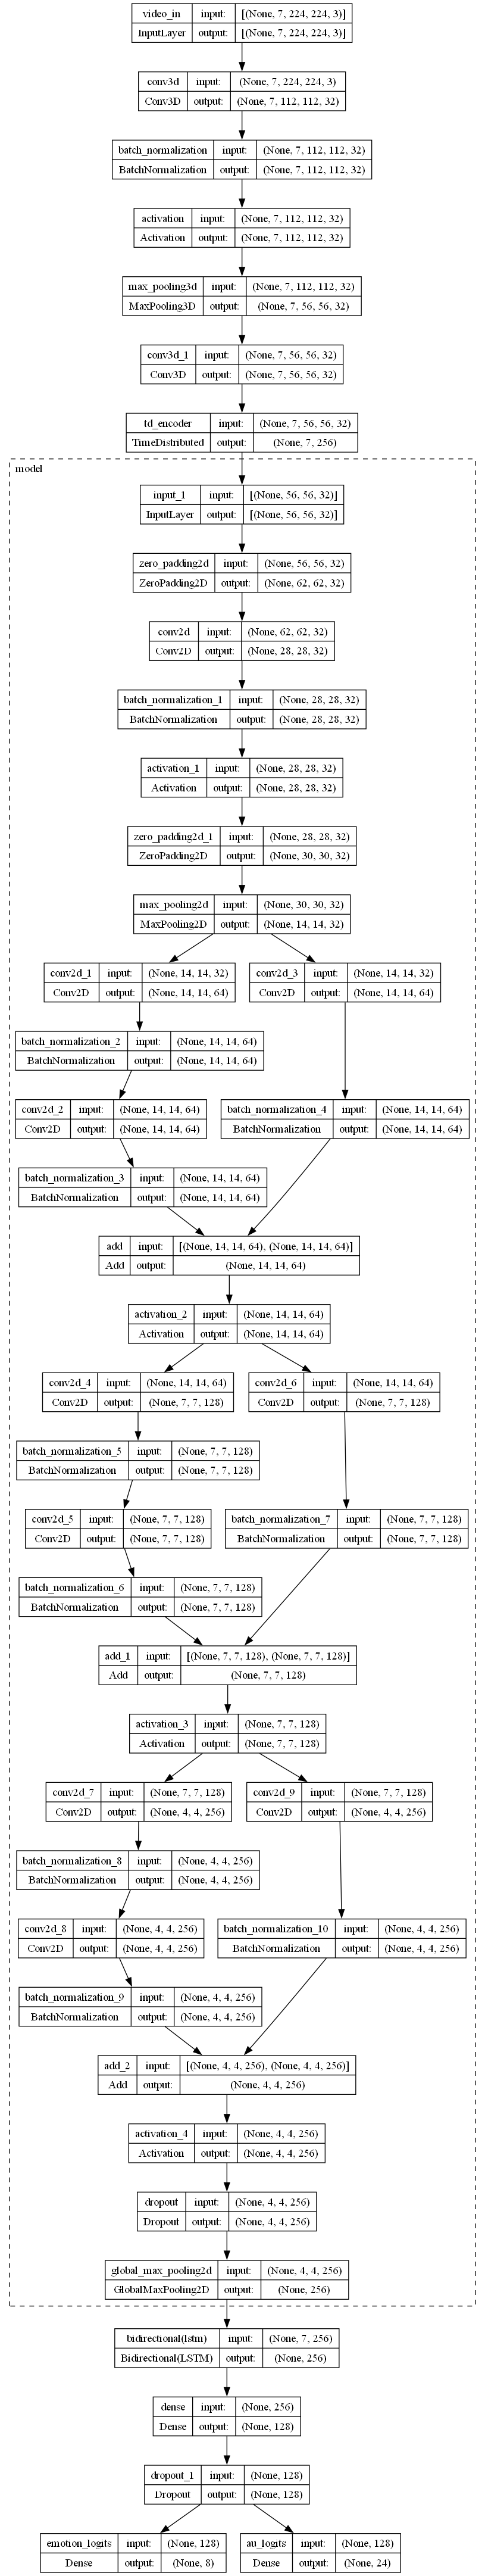

In [8]:
model = build_2d_bilstm(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS, lstm_hidden=128)
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True,expand_nested=True)

### Using Focal Loss due to sparsity of AU vectors

In [9]:
EPOCHS = 25
def decay(epoch, lr):
    if epoch == 20:
        return lr * 0.1
    return lr
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(decay)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1, callbacks=lr_scheduler)

Epoch 1/25
418/418 [==============================] - 44s 43ms/step - loss: 6.4059 - emotion_logits_loss: 6.2258 - au_logits_loss: 0.0900 - emotion_logits_sparse_categorical_accuracy: 0.1603 - au_logits_auc: 0.4824 - val_loss: 5.7125 - val_emotion_logits_loss: 5.6183 - val_au_logits_loss: 0.0471 - val_emotion_logits_sparse_categorical_accuracy: 0.3333 - val_au_logits_auc: 0.4057 - lr: 1.0000e-04
Epoch 2/25
418/418 [==============================] - 16s 37ms/step - loss: 6.0755 - emotion_logits_loss: 5.9966 - au_logits_loss: 0.0394 - emotion_logits_sparse_categorical_accuracy: 0.2536 - au_logits_auc: 0.5211 - val_loss: 5.4013 - val_emotion_logits_loss: 5.3383 - val_au_logits_loss: 0.0315 - val_emotion_logits_sparse_categorical_accuracy: 0.3714 - val_au_logits_auc: 0.4449 - lr: 1.0000e-04
Epoch 3/25
418/418 [==============================] - 16s 38ms/step - loss: 5.7211 - emotion_logits_loss: 5.6616 - au_logits_loss: 0.0297 - emotion_logits_sparse_categorical_accuracy: 0.2823 - au_logits

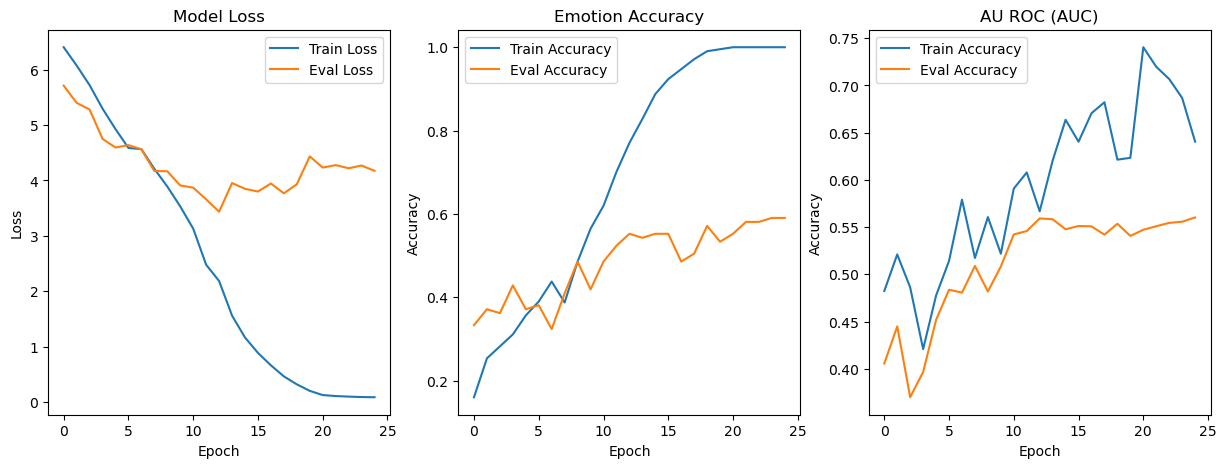

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

         AU5       0.00      0.00      0.00         2
        AU24       0.00      0.00      0.00         1
        AU43       0.00      0.00      0.00         0
        AU64       0.00      0.00      0.00         0
        AU17       0.00      0.00      0.00         8
         AU7       0.00      0.00      0.00        26
         AU1       0.67      0.27      0.38        15
        AU20       0.00      0.00      0.00         1
        AU39       0.00      0.00      0.00         0
         AU6       0.00      0.00      0.00         4
         AU4       0.93      0.58      0.72        48
         AU2       0.92      0.73      0.81        15
        AU38       0.00      0.00      0.00         1
        AU18       0.00      0.00      0.00         0
        AU14       0.00      0.00      0.00         5
        AU15       0.00      0.00      0.00         2
        AU12       0.00      0.00      0.00        15
        AU16       0.00    

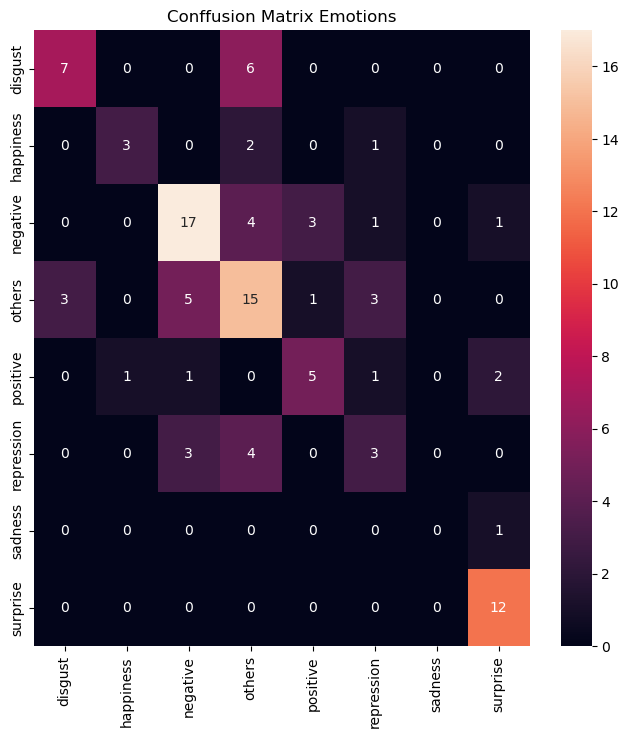

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def results(history, prefix = ""):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    emotion_train_accuracy = history.history['emotion_logits_sparse_categorical_accuracy']
    emotion_val_accuracy =  history.history['val_emotion_logits_sparse_categorical_accuracy']
    au_train_accuracy =  history.history['au_logits_auc'+ prefix]
    au_val_accuracy =  history.history['val_au_logits_auc'+ prefix]

    def plot_history(data_1, data_2, label, subplot, title):
        x = np.arange(EPOCHS)
        plt.subplot(1, 3, subplot)
        plt.plot(x, data_1, label = f"Train {label}")
        plt.plot(x, data_2, label = f"Eval {label}")
        plt.xlabel("Epoch")
        plt.ylabel(label)
        plt.legend()
        plt.title(title)

    plt.figure(figsize = (15, 5))
    plot_history(loss, val_loss, "Loss", 1, "Model Loss")
    plot_history(emotion_train_accuracy, emotion_val_accuracy, "Accuracy", 2, "Emotion Accuracy")
    plot_history(au_train_accuracy, au_val_accuracy, "Accuracy", 3, "AU ROC (AUC)")
    plt.show()

results(history, "")
def eval_model(validation_data, model):
    true_emotions = []
    true_AUs = []
    pred_emotions = []
    pred_AUs = []
    count = 0
    for video, (emotion, au_vector) in validation_data:
        count += 1
        true_emotions.append(emotion.numpy().squeeze())
        true_AUs.append(au_vector.numpy().squeeze())
        pred = model.predict(video, verbose = 0)
        pred_emotions.append(np.argmax(pred[0]))
        pred_AUs.append((pred[1] > 0.5).astype(np.int32).squeeze())
    cr_aus = classification_report(true_AUs, pred_AUs, target_names = labels.columns[:-1], zero_division=0,)
    pred_emotions = le.inverse_transform(pred_emotions)
    true_emotions = le.inverse_transform(true_emotions)
    cr_emotions = classification_report(true_emotions, pred_emotions)
    cm_emotions = confusion_matrix(true_emotions, pred_emotions)
    print(cr_aus)
    print(cr_emotions)
    plt.figure(figsize=(8,8))
    target_names_emotions =  np.unique(true_emotions)
    sns.heatmap(cm_emotions, annot=True, fmt= "d", xticklabels=target_names_emotions, yticklabels=target_names_emotions)
    plt.title("Conffusion Matrix Emotions")
    plt.show()

eval_model(validation, model)

## Sample -> Optical Flow

In [11]:
data_casme = jbl.load("../data/casme_optical_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(523, 7, 224, 224, 3)


In [12]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)

In [13]:
model = build_2d_bilstm(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS, lstm_hidden=128)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #target AU binary vectors are way too sparse, so this loss compensates this
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1, callbacks=lr_scheduler)

Epoch 1/25
418/418 [==============================] - 27s 44ms/step - loss: 6.2639 - emotion_logits_loss: 6.0788 - au_logits_loss: 0.0925 - emotion_logits_sparse_categorical_accuracy: 0.1818 - au_logits_auc_1: 0.5036 - val_loss: 5.7250 - val_emotion_logits_loss: 5.6163 - val_au_logits_loss: 0.0544 - val_emotion_logits_sparse_categorical_accuracy: 0.2381 - val_au_logits_auc_1: 0.3928 - lr: 1.0000e-04
Epoch 2/25
418/418 [==============================] - 17s 41ms/step - loss: 5.5569 - emotion_logits_loss: 5.4753 - au_logits_loss: 0.0408 - emotion_logits_sparse_categorical_accuracy: 0.3230 - au_logits_auc_1: 0.5452 - val_loss: 4.9656 - val_emotion_logits_loss: 4.9158 - val_au_logits_loss: 0.0249 - val_emotion_logits_sparse_categorical_accuracy: 0.4381 - val_au_logits_auc_1: 0.3710 - lr: 1.0000e-04
Epoch 3/25
418/418 [==============================] - 16s 39ms/step - loss: 4.8283 - emotion_logits_loss: 4.7759 - au_logits_loss: 0.0262 - emotion_logits_sparse_categorical_accuracy: 0.3995 - a

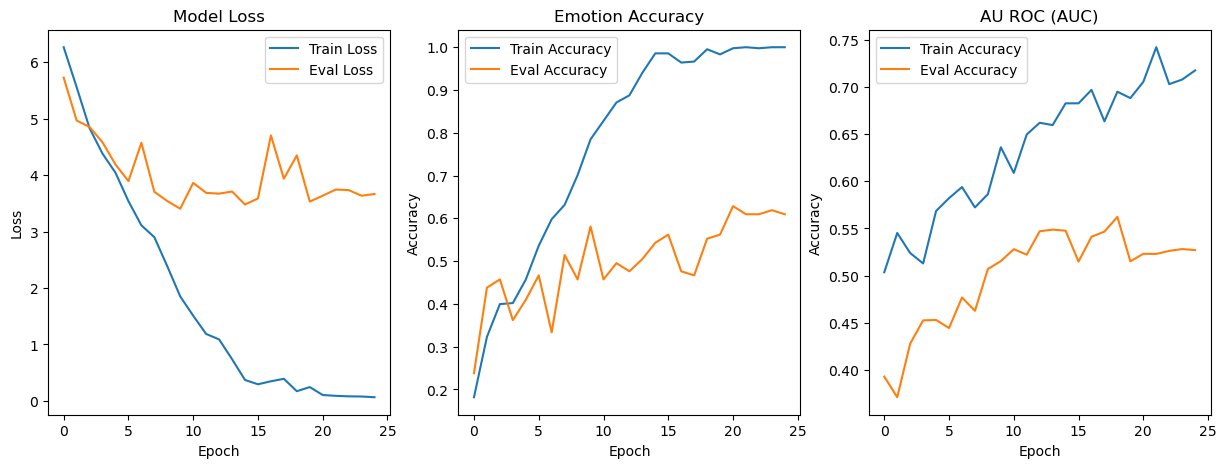

              precision    recall  f1-score   support

         AU5       0.00      0.00      0.00         2
        AU24       0.00      0.00      0.00         1
        AU43       0.00      0.00      0.00         0
        AU64       0.00      0.00      0.00         0
        AU17       0.00      0.00      0.00         8
         AU7       0.00      0.00      0.00        26
         AU1       0.75      0.60      0.67        15
        AU20       0.00      0.00      0.00         1
        AU39       0.00      0.00      0.00         0
         AU6       0.00      0.00      0.00         4
         AU4       1.00      0.60      0.75        48
         AU2       0.86      0.40      0.55        15
        AU38       0.00      0.00      0.00         1
        AU18       0.00      0.00      0.00         0
        AU14       0.00      0.00      0.00         5
        AU15       0.00      0.00      0.00         2
        AU12       1.00      0.27      0.42        15
        AU16       0.00    

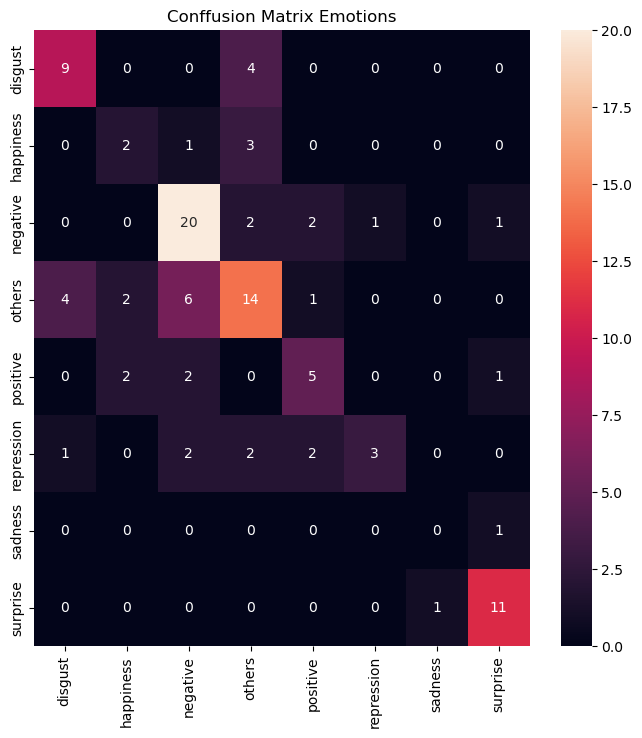

In [14]:
results(history, prefix = "_1")
eval_model(validation, model)

## Magnification -> Sample

In [15]:
data_casme = jbl.load("../data/casme_magnify_only.pkl")
print(data_casme.shape)
data_4dme = jbl.load("../data/4dme_magnify_only.pkl")
print(data_4dme.shape)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 8, 224, 224)


In [16]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)

Epoch 1/25
418/418 [==============================] - 25s 39ms/step - loss: 5.9396 - emotion_logits_loss: 5.7603 - au_logits_loss: 0.0897 - emotion_logits_sparse_categorical_accuracy: 0.2823 - au_logits_auc_2: 0.4462 - val_loss: 5.7174 - val_emotion_logits_loss: 5.6191 - val_au_logits_loss: 0.0491 - val_emotion_logits_sparse_categorical_accuracy: 0.2571 - val_au_logits_auc_2: 0.3167 - lr: 1.0000e-04
Epoch 2/25
418/418 [==============================] - 15s 37ms/step - loss: 5.3313 - emotion_logits_loss: 5.2516 - au_logits_loss: 0.0399 - emotion_logits_sparse_categorical_accuracy: 0.3660 - au_logits_auc_2: 0.5256 - val_loss: 4.8419 - val_emotion_logits_loss: 4.7876 - val_au_logits_loss: 0.0271 - val_emotion_logits_sparse_categorical_accuracy: 0.4095 - val_au_logits_auc_2: 0.3963 - lr: 1.0000e-04
Epoch 3/25
418/418 [==============================] - 15s 36ms/step - loss: 5.0248 - emotion_logits_loss: 4.9664 - au_logits_loss: 0.0292 - emotion_logits_sparse_categorical_accuracy: 0.3900 - a

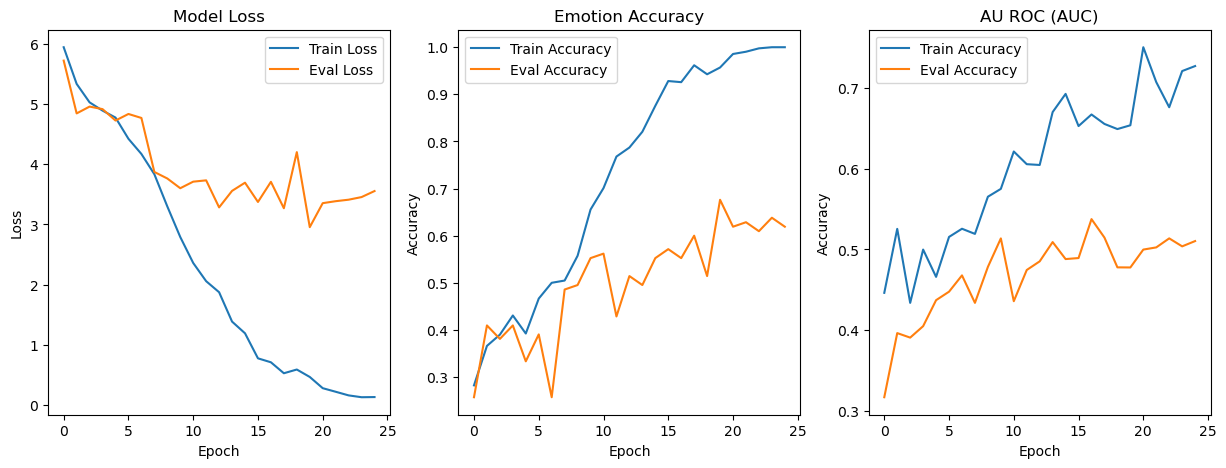

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

         AU5       0.00      0.00      0.00         2
        AU24       0.00      0.00      0.00         1
        AU43       0.00      0.00      0.00         0
        AU64       0.00      0.00      0.00         0
        AU17       0.00      0.00      0.00         8
         AU7       0.00      0.00      0.00        26
         AU1       0.60      0.20      0.30        15
        AU20       0.00      0.00      0.00         1
        AU39       0.00      0.00      0.00         0
         AU6       0.00      0.00      0.00         4
         AU4       0.93      0.29      0.44        48
         AU2       1.00      0.13      0.24        15
        AU38       0.00      0.00      0.00         1
        AU18       0.00      0.00      0.00         0
        AU14       0.00      0.00      0.00         5
        AU15       0.00      0.00      0.00         2
        AU12       0.00      0.00      0.00        15
        AU16       0.00    

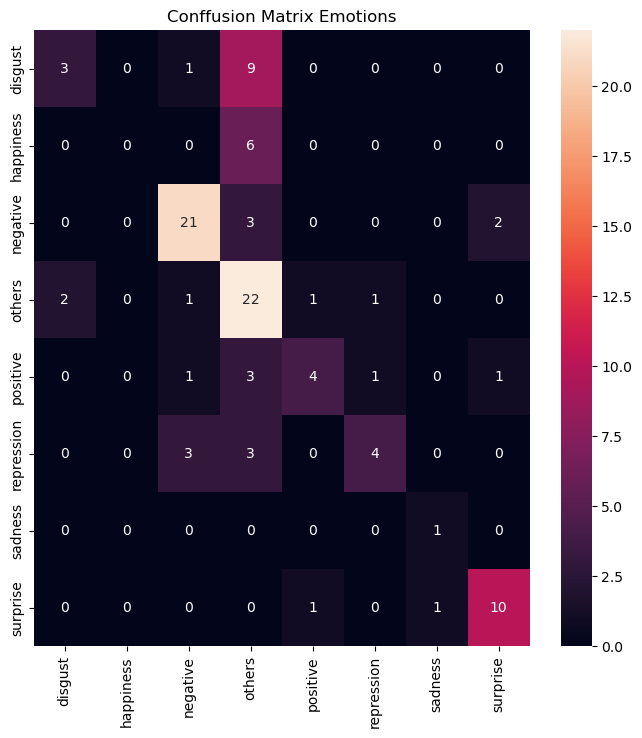

In [17]:
model = build_2d_bilstm(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS, lstm_hidden=128)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1, callbacks=lr_scheduler)
results(history, prefix = "_2")
eval_model(validation, model)

## Early fusion of Optical flow + LBP

LBPs were computed after magnification and sampling, Optical flow after directly after sampling.

In [18]:
of_casme = jbl.load("../data/casme_optical_only.pkl")
print(of_casme.shape)
of_4dme = jbl.load("../data/4dme_optical_only.pkl")
print(of_4dme.shape)
lbp_casme = jbl.load("../data/casme_magnified_lbps.pkl")
print(lbp_casme.shape)
lbp_4dme = jbl.load("../data/4dme_magnified_lbps.pkl")
print(lbp_4dme.shape)
data_casme = np.concatenate([of_casme, lbp_casme[:, :-1,..., np.newaxis]], axis=-1)
data_4dme = np.concatenate([of_4dme, lbp_4dme[:, :-1,..., np.newaxis]], axis=-1)
concatted = np.concatenate([data_casme, data_4dme], axis=0)
print(concatted.shape)
NUM_FRAMES = concatted.shape[1]
Y_SCALE = concatted.shape[2]
X_SCALE = concatted.shape[3]
CHANNELS = 1 if len(concatted.shape) <= 4 else concatted.shape[4]

(256, 7, 224, 224, 3)
(267, 7, 224, 224, 3)
(256, 8, 224, 224)
(267, 8, 224, 224)
(523, 7, 224, 224, 4)


In [19]:
del data_casme
del data_4dme
del of_4dme 
del of_casme
del lbp_casme 
del lbp_4dme

In [20]:
training = tf.data.Dataset.from_tensor_slices((concatted[train_idx], (emotions[train_idx], aus[train_idx]))).shuffle(buffer_size=len(train_idx), seed=255).batch(1).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.from_tensor_slices((concatted[test_idx], (emotions[test_idx], aus[test_idx]))).batch(1).prefetch(tf.data.AUTOTUNE)

Epoch 1/25
418/418 [==============================] - 27s 46ms/step - loss: 6.3454 - emotion_logits_loss: 6.1720 - au_logits_loss: 0.0867 - emotion_logits_sparse_categorical_accuracy: 0.1842 - au_logits_auc_3: 0.4726 - val_loss: 5.7521 - val_emotion_logits_loss: 5.6637 - val_au_logits_loss: 0.0442 - val_emotion_logits_sparse_categorical_accuracy: 0.2476 - val_au_logits_auc_3: 0.3635 - lr: 1.0000e-04
Epoch 2/25
418/418 [==============================] - 18s 42ms/step - loss: 6.1667 - emotion_logits_loss: 6.0784 - au_logits_loss: 0.0441 - emotion_logits_sparse_categorical_accuracy: 0.2368 - au_logits_auc_3: 0.4753 - val_loss: 5.4911 - val_emotion_logits_loss: 5.4205 - val_au_logits_loss: 0.0353 - val_emotion_logits_sparse_categorical_accuracy: 0.3429 - val_au_logits_auc_3: 0.4328 - lr: 1.0000e-04
Epoch 3/25
418/418 [==============================] - 17s 41ms/step - loss: 5.8730 - emotion_logits_loss: 5.8073 - au_logits_loss: 0.0329 - emotion_logits_sparse_categorical_accuracy: 0.2512 - a

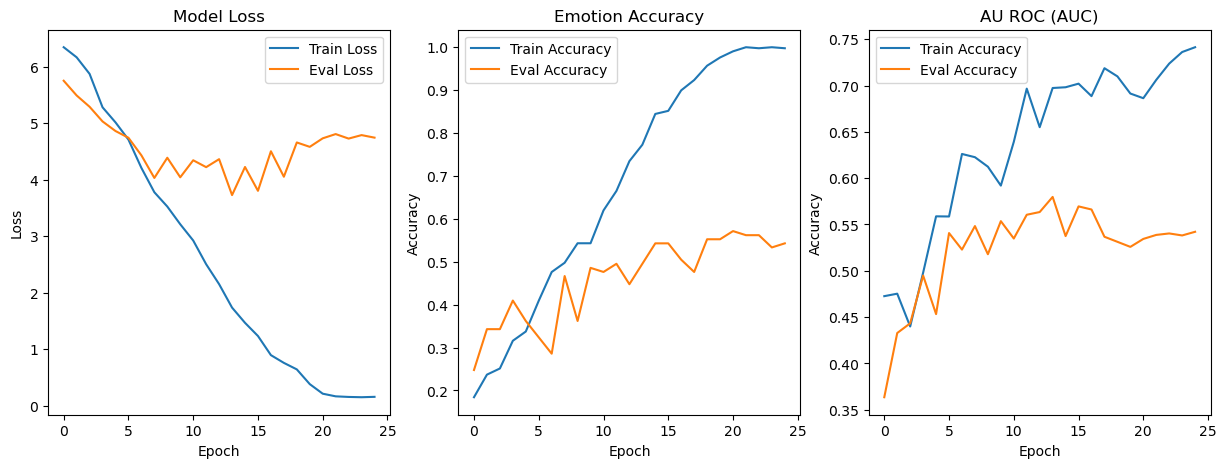

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

              precision    recall  f1-score   support

         AU5       0.00      0.00      0.00         2
        AU24       0.00      0.00      0.00         1
        AU43       0.00      0.00      0.00         0
        AU64       0.00      0.00      0.00         0
        AU17       0.00      0.00      0.00         8
         AU7       1.00      0.04      0.07        26
         AU1       0.80      0.27      0.40        15
        AU20       0.00      0.00      0.00         1
        AU39       0.00      0.00      0.00         0
         AU6       0.00      0.00      0.00         4
         AU4       0.96      0.52      0.68        48
         AU2       0.70      0.47      0.56        15
        AU38       0.00      0.00      0.00         1
        AU18       0.00      0.00      0.00         0
        AU14       0.00      0.00      0.00         5
        AU15       0.00      0.00      0.00         2
        AU12       1.00      0.13      0.24        15
        AU16       0.00    

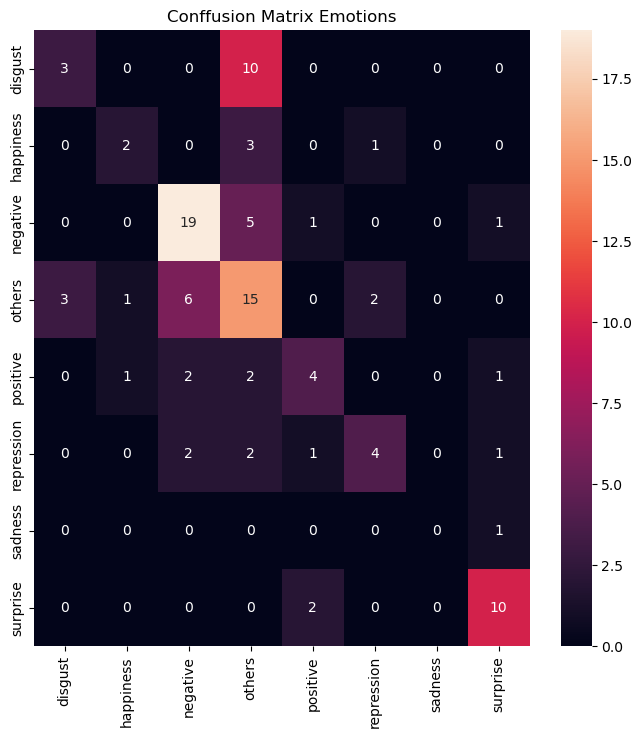

In [21]:
model = build_2d_bilstm(input_shape=(NUM_FRAMES, Y_SCALE, X_SCALE, CHANNELS), num_emotions=NUM_EMOTIONS, num_aus=NUM_AUS, lstm_hidden=128)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "emotion_logits": weighted_loss,
        "au_logits": tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True) #tf.keras.losses.BinaryCrossentropy(from_logits=False)
    },
    metrics={
        "emotion_logits": tf.keras.metrics.SparseCategoricalAccuracy(),
         "au_logits": tf.keras.metrics.AUC(multi_label=True)
    },
    loss_weights={"emotion_logits": 1.0, "au_logits": 2.0
     },
)
history = model.fit(training, validation_data=validation, epochs = EPOCHS, verbose=1, callbacks=lr_scheduler)
results(history, prefix = "_3")
eval_model(validation, model)

## Results

So far everything was wrong below
```
So far the models involving optical flow were performing the best, it is seen that with optical flow which was extracted from motion magnified clips model may perform slightly better in classification of emotions, but on the other hand loses performance in AU recognition, depending on the case, for instance, it was noticed that when training sample is increased to 80% of data, model which is trained on optical flow extracted from motion magnified clips starts to perform worse in both tasks, than the one which is trained with optical flow without magnifiction was before sampling. Best performer in terms of classification and AU recognition is model which was trained on optical flow (no magnifiction was applited before sampling) and LBP features. The last LBP feature map was dropped, so model "sees" the flow and it's subsequent LBP map. Nevertheless in all cases, increasing the number of residual blocks, particularly adding an extra downsampling block with 512 filters caused the model to converge very rapidly but also led to excessive model complexity. Consequently, the architecture was simplified by removing the 512-filter residual downsampling blocks, retaining only two downsampling residual blocks with 256 filters. This modification significantly reduced model size, although it required more epochs to reach near-perfect emotion classification accuracy. Because AU annotations are highly sparse and imbalanced, only AUs present in both datasets (4DME and CASME) were retained, rather than forming a union of all AUs. To solve label imbalance problem, the AU head employed binary focal cross-entropy loss, while the emotion classification head used a weighted sparse categorical cross-entropy loss to account for class imbalance in emotions.
```